<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/Neo4j/European_Gas_Pipeline_Knowledge_Graph_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# European Gas Pipeline Knowledge Graph Demo

This Demo will show how to create a Knowledge Graph for the European Gas Pipeline Network.

You can access the dataset in this [link](https://zenodo.org/records/5079748#.Yl6MOvNBz0p) and a full report [here](https://elib.dlr.de/139217/1/scigrid_gas_EMAP.pdf).





## Gas transmission networks consist of different components:
---
**PipeLines**: PipeLines allow for the transmission of gas from one node to another. PipeLines are georeferenced by an ordered list of nodes.

**PipeSegments**: PipeSegments are almost identical to PipeLines — however, they are only allowed to connect two nodes. Hence, any PipeLines element (with three or more nodes) can easily be converted into multiple PipeSegments elements.

**Compressors**: Compressors represent compressor stations, which increases the pressure of the gas, and thus allows the gas to flow from one node to another node. A gas compressor station contains several gas compressor units (turbines).

**LNGs**: LNGs is the acronym for Liquefied natural gas. There are several LNG terminals and LNG storage in Europe, as some gas gets transported to Europe via ships.

**Storages**: Storages are another network component. Surplus gas can be stored underground (e.g. in old gas fields or salt caverns) and used during low supply or high demand periods.

**Consumers**: Consumers is the term used for gas users, which can include households, industries, and commercial uses. This data set will be generated through a master project, and it excludes power plants.

**PowerPlants**: PowerPlants is the term for gas used by power plants only.

**Productions**: These can be wells inside a country where gas is pumped out of the ground. Most of the gas used in Europe comes from outside of the EU. However, there are several smaller gas production sites scattered throughout Europe.

**BorderPoints**: BorderPoints are facilities at borders between countries, which are mainly used to meter the gas flow from one country to another.

## The Structure of those elements is the same for all component:
---
**id**: A string that is the ID of the element, and must be unique.

**name**: A string that is the name of the facility, such as “Compressor Radeland.” In most cases this is not supplied.

**source_id**: A list of strings that are the data sources of the element. As several elements from different sources could have been combined into a single element, one might need to know the original data sources.

**node_id**: The ID of a geo-referenced node to which an element of the network is associated to. For a compressor, this will be just a single node_id. However, for a gas pipeline this entry would be a list of at least two node_id values: the starts node id and the end node id.

**lat**: The latitude value of an element. For elements of type PipeLines and PipeSegments, lat is a list of latitude values. Throughout the SciGRID_gas project, the projection World Geodetic system 1984 (epsg:4326) will be used.

**long**: The longitude analog to lat.

**country_code**: A string indicating the two-digit ISO country code (Alpha-2 code, see Chapter 10.6 for list of countries and their codes) of the associated node of elements or list of nodes in case of PipeLines or PipeSegments.

**comment**: An arbitrary comment that is associated with the element. In most cases this is not supplied.

**tags**: This dictionary is reserved for OpenStreetMap data. It contains all associated key:value-pairs of an OpenStreetMap item.

Map of INET dataset 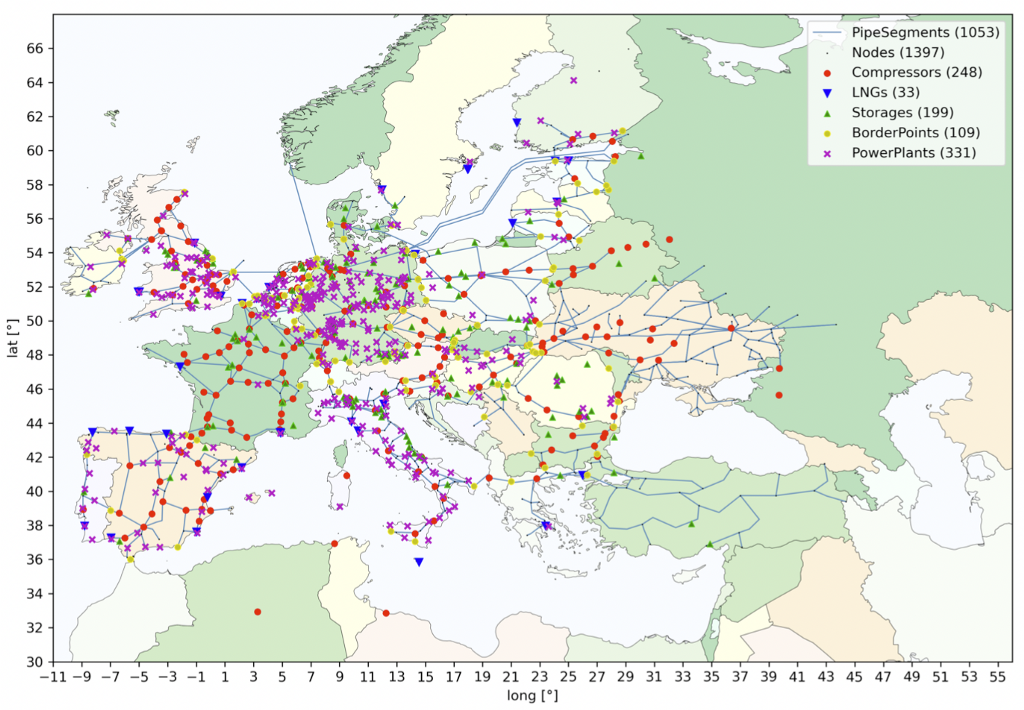

## Notebook Preparation

In [1]:
# Install necessary libraries, uncomment if required
!pip install graphdatascience


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.0/198.0 kB 14.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.18.0-py3-none-any.whl size=273862 sha256=b16bd6e78fa125f2a1793adba6ecb0a994a728e177a1cec24a356e1c24103249
  Stored in directory: /root/.cache/pip/wheels/e7/e1/a0/dd7c19192f5383ff57d02a6c126cbfe4b7b2ae82f70c6994ce
Successfully built neo4j


In [2]:
from graphdatascience import GraphDataScience
import time
import numpy as np
import pandas as pd
from google.colab import drive

In [3]:
# Connect to the Sandbox database
uri  = 'bolt://3.92.206.237:7687'
user = 'neo4j'
pwd  = 'painters-seam-scratchpads'

# Create Python GDS Object
gds = GraphDataScience(uri, auth=(user, pwd), database="neo4j")

In [4]:
# File uploading Options, uncomment as required

# Option 1: Import CSV File from Github

path = 'https://raw.githubusercontent.com/javier-jaime/Tool-Crib/master/Neo4j/EGP_Data/'

# Option 2: Mount & Import CSV File from Google Drive, comment/uncomment as required

# drive.mount('/content/drive')

# path = 'drive/MyDrive/Colab Notebooks/EGP_Data/'

# Option 3: Upload Log to temporary session storage and import, comment/uncomment as required

# path = ''

## Load Components

In [5]:
# creating Unique constraints for all the components

gds.run_cypher("CREATE CONSTRAINT BorderPoints IF NOT EXISTS FOR (n:BorderPoint) REQUIRE n.id IS UNIQUE")
gds.run_cypher("CREATE CONSTRAINT Compressors IF NOT EXISTS FOR (n:Compressor) REQUIRE n.id IS UNIQUE")
gds.run_cypher("CREATE CONSTRAINT Consumers IF NOT EXISTS FOR (n:Consumer) REQUIRE n.id IS UNIQUE")
gds.run_cypher("CREATE CONSTRAINT LNGs IF NOT EXISTS FOR (n:LNG) REQUIRE n.id IS UNIQUE")
gds.run_cypher("CREATE CONSTRAINT Nodes IF NOT EXISTS FOR (n:Node) REQUIRE n.id IS UNIQUE")
gds.run_cypher("CREATE CONSTRAINT PowerPlants IF NOT EXISTS FOR (n:PowerPlant) REQUIRE n.id IS UNIQUE")
gds.run_cypher("CREATE CONSTRAINT Productions IF NOT EXISTS FOR (n:Production) REQUIRE n.id IS UNIQUE")
gds.run_cypher("CREATE CONSTRAINT Storages IF NOT EXISTS FOR (n:Storage) REQUIRE n.id IS UNIQUE")

""


In [6]:
# Load Border Points from CSV file

file_name = 'BorderPoints.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(b:BorderPoint {id:id})
ON CREATE SET b.name          = name,
              b.country_code  = country_code,
              b.source_id     = source_ids[0],
              b.node_id       = node_ids[0],
              b.loc           = loc,
              b              += params
""", params)

""


In [7]:
# Load Compressors from CSV file

file_name = 'Compressors.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(c:Compressor {id:id})
ON CREATE SET c.name          = name,
              c.country_code  = country_code,
              c.source_id     = source_ids[0],
              c.node_id       = node_ids[0],
              c.loc           = loc,
              c              += params
""", params)

""


In [8]:
# Load Consumers from CSV file

file_name = 'Consumers.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(c:Consumer {id:id})
ON CREATE SET c.name          = name,
              c.country_code  = country_code,
              c.source_id     = source_ids[0],
              c.node_id       = node_ids[0],
              c.loc           = loc,
              c              += params
""", params)

""


In [9]:
# Load LNGs from CSV file

file_name = 'LNGs.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(l:LNG {id:id})
ON CREATE SET l.name          = name,
              l.country_code  = country_code,
              l.source_id     = source_ids,
              l.node_id       = node_ids[0],
              l.loc           = loc,
              l              += params
""", params)

""


In [10]:
# Load Storages from CSV file

file_name = 'Storages.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(s:Storage {id:id})
ON CREATE SET s.name          = name,
              s.country_code  = country_code,
              s.source_id     = source_ids,
              s.node_id       = node_ids[0],
              s.loc           = loc,
              s              += params
""", params)

""


In [11]:
# Load Productions from CSV file

file_name = 'Productions.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(p:Production {id:id})
ON CREATE SET p.name          = name,
              p.country_code  = country_code,
              p.source_id     = source_ids[0],
              p.node_id       = node_ids[0],
              p.loc           = loc,
              p              += params
""", params)

""


In [12]:
# Load Power Plants from CSV file

file_name = 'PowerPlants.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(pp:PowerPlant {id:id})
ON CREATE SET pp.name          = name,
              pp.country_code  = country_code,
              pp.source_id     = source_ids,
              pp.node_id       = node_ids[0],
              pp.loc           = loc,
              pp              += params
""", params)

""


In [13]:
# Load Nodes (junction points) from CSV file

file_name = 'Nodes.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     replace(row.name, '"','') as name,
     row.country_code as country_code,
     apoc.convert.fromJsonList(row.source_id) as source_ids,
     apoc.convert.fromJsonList(row.node_id) as node_ids,
     point({latitude:toFloat(row.lat), longitude:toFloat(row.long)}) as loc,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MERGE(n:Node {id:id})
ON CREATE SET n.name          = name,
              n.country_code  = country_code,
              n.source_id     = source_ids[0],
              n.node_id       = node_ids[0],
              n.loc           = loc,
              n              += params
""", params)

""


In [14]:
# Load Pipe Segments from CSV file

file_name = 'PipeSegments.csv'
params = {'url': path + file_name}

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM $url as row
FIELDTERMINATOR ';'
WITH row.id as id,
     row.name as name,
     apoc.convert.fromJsonList(row.country_code) as countries,
     apoc.convert.fromJsonList(row.node_id) as nodes,
     apoc.convert.fromJsonMap(replace(row.param, 'None', 'null')) as params
MATCH (start_p:Node {id:nodes[0]})
MATCH (end_p:Node {id:nodes[1]})
MERGE (start_p)-[pipe:PIPE {id:id}]->(end_p)
ON CREATE SET pipe.name = name,
              pipe += params
""", params)

""


## Exploratory Data Analysis (EDA)


The dataset provided is pretty clean, we just need to look at basic stats.

In [15]:
# Nodes Count
query01 = """
CALL db.labels() YIELD label
CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as count',{}) YIELD value
RETURN label as nodes, value.count as nodeCount
ORDER BY nodeCount DESC
"""

df1 = gds.run_cypher(query01, params)
df1

,nodes,nodeCount
0,Node,5009
1,Consumer,1357
2,PowerPlant,310
3,Storage,297
4,Compressor,248
5,BorderPoint,109
6,Production,104
7,LNG,32


In [16]:
# Meta Stats
query02 = '''
CALL apoc.meta.stats()
'''
df2 = gds.run_cypher(query02, params)
df2

,labelCount,relTypeCount,propertyKeyCount,nodeCount,relCount,labels,relTypes,relTypesCount,stats
0,8,1,83,7466,6526,"{'Storage': 297, 'PowerPlant': 310, 'Consumer'...","{'()-[:PIPE]->()': 6526, '(:Node)-[:PIPE]->()'...",{'PIPE': 6526},"{'relTypeCount': 1, 'labelCount': 8, 'relTypes..."


# Graph Data Science

In this section we will answer the key questions.

## Node Importance

Which is the most important Node or **Junction** in this network? The answer depends on what important means in a given context.

In this demo we will use **centrality algorithms** to find the most **Critical Nodes** in the network.


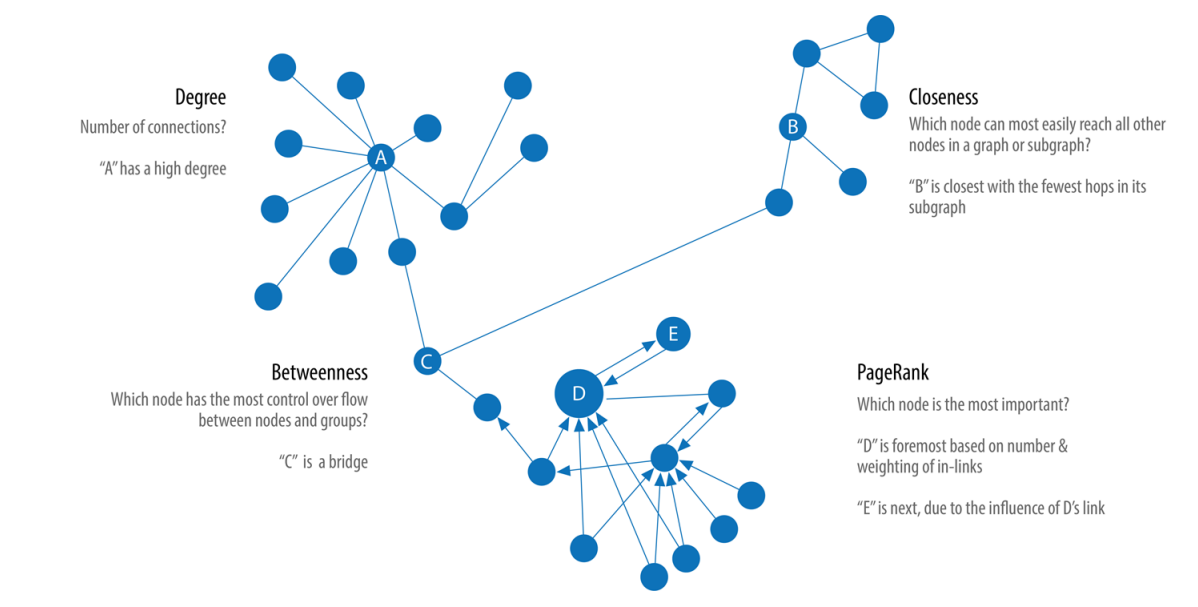

### Degree Centrality
The Degree Centrality algorithm measures the number of both incoming and outgoing relationships from a node to find **Popular Nodes** within a graph. Degree Centrality is an essential component of any attempt to determine the most critical nodes in a network. Note that the **Orientation** is a key parameter for the degree, UNDIRECTED will consider incoming and outgoing nodes.

In [17]:
# Degree Centrality Graph Projection

query09 = """
CALL gds.graph.project(
  'degreeCentralityPipes',
  'Node',
  {
    PIPE: {
      orientation: "UNDIRECTED"
    }
  }
)
"""
gds.run_cypher(query09)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Node': {'label': 'Node', 'properties': {}}}","{'PIPE': {'aggregation': 'DEFAULT', 'orientati...",degreeCentralityPipes,5009,13052,8842


In [18]:
# Top ten nodes by degree centrality
query10 = """
CALL gds.degree.stream('degreeCentralityPipes')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).id AS id, score AS degree
ORDER BY degree DESC, id ASC
LIMIT 10
"""
gds.run_cypher(query10)

,id,degree
0,LKD_N_38,14.0
1,N_144_L_LMGN,13.0
2,INET_N_1679,11.0
3,INET_N_408,11.0
4,LKD_N_147,11.0
5,LKD_N_363,11.0
6,N_72_L_LMGN,11.0
7,INET_N_1071,10.0
8,INET_N_1118,10.0
9,INET_N_1579,10.0


In [19]:
# dropping an existing graph projection, if required
drop_query = "CALL gds.graph.drop('degreeCentralityPipes') YIELD graphName;"
gds.run_cypher(drop_query)

,graphName
0,degreeCentralityPipes


### Page Rank Algorithm
A famous algorithm to determine the importance of a node is **Page Rank**, originally designed to rank the web pages, the underlying assumption is that a web page is only as important as the pages that link to it. The algorithm measures the **Significance** of each node within the graph by computing the ranking of the nodes based on the number of incoming relationships or links.

In [20]:
# Create a Graph Projection
query04 = """CALL gds.graph.project(
                'pipelines',
                'Node',
                'PIPE'
            )
            YIELD
                graphName, nodeProjection, nodeCount, relationshipProjection, relationshipCount
"""

gds.run_cypher(query04)

,graphName,nodeProjection,nodeCount,relationshipProjection,relationshipCount
0,pipelines,"{'Node': {'label': 'Node', 'properties': {}}}",5009,"{'PIPE': {'aggregation': 'DEFAULT', 'orientati...",6526


In [21]:
G, res = gds.graph.project(
    'pipes',
    'Node',
    "PIPE"
)
type(res)

pandas.core.series.Series

In [22]:
print(res)

nodeProjection                {'Node': {'label': 'Node', 'properties': {}}}
relationshipProjection    {'PIPE': {'aggregation': 'DEFAULT', 'orientati...
graphName                                                             pipes
nodeCount                                                              5009
relationshipCount                                                      6526
projectMillis                                                           112
Name: 0, dtype: object


In [23]:
G.node_count(), G.relationship_count()

(5009, 6526)

In [24]:
G.degree_distribution()

min      0.000000
max     12.000000
p90      3.000000
p999     7.000000
p99      5.000000
p50      1.000000
p75      2.000000
p95      3.000000
mean     1.302855
dtype: float64

In [25]:
# Page Rank Algorith
res = gds.pageRank.stream(G)
res

,nodeId,score
0,2457,0.331688
1,2458,0.431934
2,2459,0.333572
3,2460,0.597695
4,2461,0.515261
...,...,...
5004,7461,0.411465
5005,7462,0.319784
5006,7463,0.267938
5007,7464,0.213750


In [26]:
# top 10 by page rank algoritm
res.sort_values(by='score', ascending=False)[:10]

,nodeId,score
2848,5305,4.861119
2852,5309,4.331437
514,2971,4.225036
1813,4270,3.832889
1708,4165,3.320917
1769,4226,3.236406
1776,4233,3.128835
1709,4166,2.935067
2779,5236,2.765317
2112,4569,2.691821


In [27]:
# Find The Most Critical Node
query05 = """
MATCH (n:Node)
WHERE ID(n) = 5305
RETURN n.id
"""
gds.run_cypher(query05, params)

,n.id
0,LKD_N_40


In [28]:
# writing the page ranks of the nodes
query06= """CALL gds.pageRank.write('pipes',
    {
        writeProperty: 'pagerank'
    }
)
YIELD nodePropertiesWritten, ranIterations"""

gds.run_cypher(query06)

,nodePropertiesWritten,ranIterations
0,5009,20


In [29]:
# Top ten nodes Page Rank and Volume

query08 = """MATCH (n:Node)<-[r:PIPE]-(:Node)
RETURN n.id AS id, n.country_code AS countryCode, round(n.pagerank,2) AS pagerank, round(sum(r.max_cap_M_m3_per_d),2) as maximumAnnualGasVolume
ORDER BY pagerank DESC, id ASC
LIMIT 10"""

gds.run_cypher(query08)


,id,countryCode,pagerank,maximumAnnualGasVolume
0,LKD_N_40,DE,4.86,195.52
1,LKD_N_44,DE,4.33,54.79
2,N_183_M_LMGN,MD,4.23,82.19
3,SEQ_1813__M_LMGN,MD,3.83,54.79
4,SEQ_7563__L_LMGN,XX,3.32,82.19
5,N_32_M_LMGN,RU,3.24,54.79
6,N_85_M_LMGN,RU,3.13,54.79
7,SEQ_7577__L_LMGN,XX,2.94,27.40
8,SEQ_2409_p,AZ,2.77,54.79
9,INET_N_408,UA,2.69,164.38


In [30]:
# Nodes Paths Starting from an Node ID and a Limit # (maximum rows)

params = {'id': 'INET_N_856', 'l': 20}
query03="""
MATCH p=(start:Node)-[:PIPE*]->(next)
WHERE not ((next)-[:PIPE]->()) AND start.id=$id
RETURN DISTINCT [t in nodes(p) | t.id] as nodesPath
LIMIT $l
"""
df3 = gds.run_cypher(query03, params)
df3

,nodesPath
0,"[INET_N_856, SEQ_7_p, NutsCons_1150]"
1,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
2,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
3,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
4,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
5,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
6,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
7,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
8,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."
9,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,..."


### Betweenness Centrality
The **Betweenness Centrality** algorithm measures the centrality within a graph based on the **shortest paths**. The betweenness centrality for each node is the total number of these shortest paths that pass through the node. The Score determines the **Most Important Hubs** in the Network.


In [31]:
# Betweeness Centrality Graph Projection
query11 = "CALL gds.graph.project('betweennessPipes', 'Node', 'PIPE')"
gds.run_cypher(query11)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Node': {'label': 'Node', 'properties': {}}}","{'PIPE': {'aggregation': 'DEFAULT', 'orientati...",betweennessPipes,5009,6526,182


In [32]:
# Run a Memory Estimate before the query
query12 = """
CALL gds.betweenness.write.estimate('betweennessPipes', { writeProperty: 'betweenness' })
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
"""

gds.run_cypher(query12)

,nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
0,5009,6526,1404192,1404192,1371 KiB


In [33]:
# Betweenness Centrality Distribution Stats
query13 = """
CALL gds.betweenness.stats('betweennessPipes')
YIELD centralityDistribution
RETURN centralityDistribution.min AS minimumScore, centralityDistribution.mean AS meanScore, centralityDistribution.max AS maxScore
"""
gds.run_cypher(query13)

,minimumScore,meanScore,maxScore
0,0.0,17763.981421,864215.999992


In [34]:
# Top ten nodes by Betweenness Centrality
query14 = """
CALL gds.betweenness.stream('betweennessPipes')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).id AS id, round(score,2) as score
ORDER BY score DESC, id ASC
LIMIT 10
"""

gds.run_cypher(query14)

,id,score
0,INET_N_984,864212.91
1,LKD_N_38,607789.70
2,LKD_N_492,601340.02
3,INET_N_229,598424.32
4,SEQ_19574_p,598029.02
5,SEQ_19575_p,597328.02
6,LKD_N_491,597240.49
7,LKD_N_493,596627.02
8,SEQ_719__L_LMGN,595311.72
9,LKD_N_165,594963.55


### Louvain Modularity (Cluster Detection)
This method is used to find the communities (or rings) in large networks. Modularity is a measure of how well groups have been partitioned into clusters.

In [35]:
# Top ten clusters by Louvan Modularity
query16 = """
CALL gds.louvain.stream('pipes')
YIELD nodeId, communityId
RETURN
	communityId,
    SIZE(COLLECT(gds.util.asNode(nodeId).id)) AS number_of_nodes,
	COLLECT(gds.util.asNode(nodeId).id) AS ids,
    COLLECT(gds.util.asNode(nodeId).country_code) AS country_codes
ORDER BY number_of_nodes DESC, communityId;
"""
df16 = gds.run_cypher(query16)
df16.head(10)

,communityId,number_of_nodes,ids,country_codes
0,3417,425,"[INET_N_830, INET_N_31, SEQ_436_p, INET_N_855,...","[GR, GR, GR, GR, GR, TR, TR, TR, TR, TR, TR, T..."
1,851,280,"[INET_N_1328, INET_N_1124, SEQ_14826_p, INET_N...","[EE, EE, EE, EE, FI, UA, UA, UA, UA, UA, UA, U..."
2,3777,239,"[SEQ_10293__M_LMGN, N_1757_S_LMGN, SEQ_10865__...","[NL, NL, NL, NL, NL, NL, NL, NL, NL, NL, NL, N..."
3,3974,231,"[SEQ_6833__L_LMGN, SEQ_17253_p, SEQ_17262_p, S...","[PL, PL, PL, PL, PL, PL, DE, DE, DE, DE, DE, D..."
4,4000,221,"[SEQ_5103__L_LMGN, SEQ_1132_p, LKD_N_0, LKD_N_...","[CH, NL, DE, DE, DE, DE, DE, DE, DE, DE, DE, D..."
5,2672,218,"[INET_N_753, INET_N_1731, INET_N_1131, INET_N_...","[SK, SK, BY, BY, BY, BY, BY, UA, UA, UA, UA, U..."
6,4806,199,"[INET_N_1373, SEQ_167_p, INET_N_1264, INET_N_1...","[IT, IT, IT, AL, AL, AL, AL, AL, IT, IT, IT, I..."
7,3821,189,"[N_1736_S_LMGN, N_1737_S_LMGN, N_1378_S_LMGN, ...","[CH, CH, CH, CH, CH, AT, AT, CH, AT, AT, CH, A..."
8,3945,186,"[N_735_M_LMGN, N_736_M_LMGN, N_1843_S_LMGN, N_...","[IT, IT, IT, IT, IT, IT, IT, IT, IT, IT, IT, I..."
9,4948,186,"[INET_N_1613, INET_N_1010, INET_N_1087, INET_N...","[IT, IT, IT, AT, AT, AT, AT, AT, AT, HR, HR, H..."


In [36]:
# Bottom 10 Clusters by Louvain Modularity
df16.tail(10)

,communityId,number_of_nodes,ids,country_codes
65,4384,1,[NutsCons_454],[DE]
66,4396,1,[NutsCons_495],[DE]
67,4454,1,[NutsCons_367],[DE]
68,4455,1,[SEQ_18750_p],[DE]
69,4535,1,[NutsCons_496],[DE]
70,4546,1,[NutsCons_207],[DE]
71,4581,1,[SEQ_19734_p],[DE]
72,4681,1,[LKD_N_461],[DE]
73,4706,1,[LKD_N_513],[DE]
74,4710,1,[INET_N_947],[DE]


### Path Finding
Like all other graph algorithm categories, there are several alternatives for pathfinding. The goal of pathfinding algorithms is to find the shortest path between two or more nodes. Dijkstra’s algorithm is one of the most common shortest path algorithms used. A* and Yen’s algorithm are the other alternatives in Neo4j GDS.

In [37]:
# Path Finding Graph Projection
query17 = """
CALL gds.graph.project(
    'routes-weighted',
    'Node',
    'PIPE',
        {
            relationshipProperties: 'length_km'
        }
)
"""

gds.run_cypher(query17)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Node': {'label': 'Node', 'properties': {}}}","{'PIPE': {'aggregation': 'DEFAULT', 'orientati...",routes-weighted,5009,6526,286


In [38]:
# Shortest Path by Dijkstra Algorithm from Source to Target Node

params = {'s_id': 'INET_N_856', 't_id': 'NutsCons_1003'}

query18 = """
MATCH (source:Node {id: $s_id}), (target:Node {id: $t_id})
CALL gds.shortestPath.dijkstra.stream('routes-weighted', {
    sourceNode: source,
    targetNode: target,
    relationshipWeightProperty: 'length_km'
})
YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
RETURN
    index,
    gds.util.asNode(sourceNode).id AS sourceNodeName,
    gds.util.asNode(targetNode).id AS targetNodeName,
    totalCost as totalDistance,
    [nodeId IN nodeIds | gds.util.asNode(nodeId).id] AS nodeIDs,
    costs as distances
ORDER BY index
"""
gds.run_cypher(query18, params)

,index,sourceNodeName,targetNodeName,totalDistance,nodeIDs,distances
0,0,INET_N_856,NutsCons_1003,649.707706,"[INET_N_856, SEQ_7_p, INET_N_1829, INET_N_329,...","[0.0, 55.420951, 110.841205, 220.1634910000000..."
